In [71]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

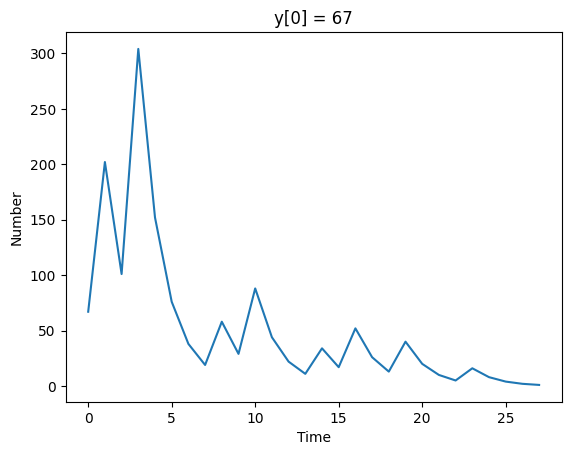

In [72]:
# generate some data
val = 67
nums = [val]
while val != 1:
    if val % 2 == 0:
        val /= 2
    else:
        val = 3 * val + 1
    nums.append(val)

# plot the data
plt.plot(nums)
plt.xlabel("Time")
plt.ylabel("Number")
plt.title("y[0] = 67")
plt.savefig("figs/3xplus1.png")

In [73]:
# Visualization of prediction
N = 1000
series = (
    np.sin(np.linspace(0, 100, N)) + np.random.randn(N) + 0.5 * np.linspace(0, 20, N)
)

# split into past and future
future_N = 300
past = series[:-future_N]
future = series[-future_N:]

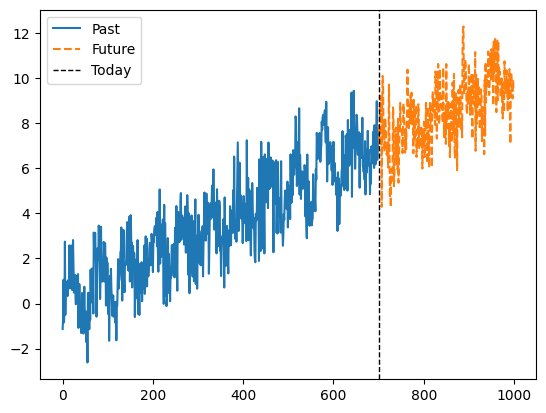

In [74]:
def plot_past_future():
    plt.plot(np.arange(N - future_N), past, label="Past")
    plt.plot(np.arange(N - future_N, N), future, "--", label="Future")
    plt.axvline(x=N - future_N, color="k", linestyle="--", linewidth=1, label="Today")


plot_past_future()
plt.legend()
plt.savefig("figs/simple_time_series.png")

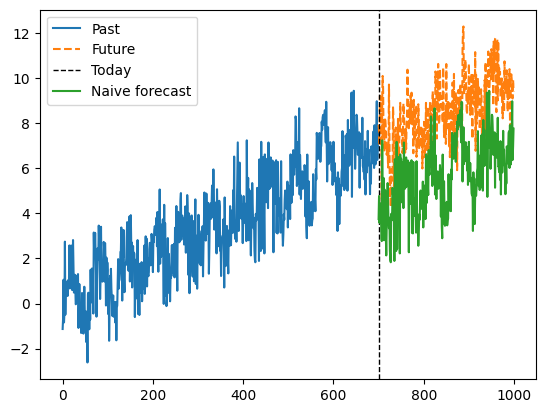

In [75]:
# Naive approach - just shift the series by some amount
naive_forecast = past[-future_N:]

plot_past_future()
plt.plot(np.arange(N - future_N, N), naive_forecast, label="Naive forecast")
plt.legend()

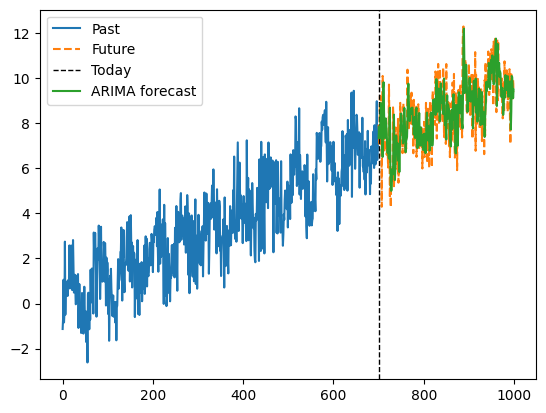

In [76]:
from statsmodels.tsa.arima.model import ARIMA

pred = np.zeros_like(future)
for i in range(future_N):
    model = ARIMA(
        np.concatenate((past, future[:i])),
        order=(1, 1, 0)).fit()
    pred[i] = model.forecast()[0]

plot_past_future()
plt.plot(np.arange(N - future_N, N), pred, label="ARIMA forecast")
plt.legend()

MAPE: 12.06%


Text(0, 0.5, 'Relative error')

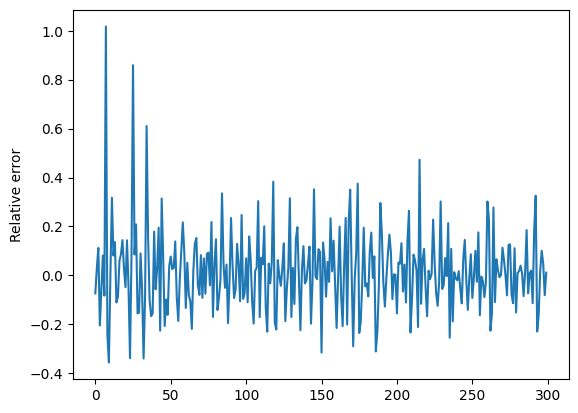

In [77]:
p_diff = (pred - future) / future
plt.plot(p_diff) 
print(f"MAPE: {np.abs(p_diff).mean():.2%}")
plt.ylabel("Relative error")

In [78]:
# prepare the data for RNN
# define some constants
INPUT_WIDTH = 10
BATCH_SIZE = 32

def to_ds(data, input_width=INPUT_WIDTH, batch_size=BATCH_SIZE):
    # chop the last input_width from the data to define the targets
    input_data = data[:-input_width]
    targets = data[input_width:]
    return tf.keras.utils.timeseries_dataset_from_array(
        input_data, 
        targets, 
        sequence_length=input_width, 
        batch_size=batch_size
    )

# illustrate what the to_ds function does
indices = np.arange(10)
i_ds = to_ds(indices, 3, batch_size=1)
for sample in i_ds:
    print("Input:",sample[0])
    print("Target:",sample[1])

Input: tf.Tensor([[0 1 2]], shape=(1, 3), dtype=int64)
Target: tf.Tensor([3], shape=(1,), dtype=int64)
Input: tf.Tensor([[1 2 3]], shape=(1, 3), dtype=int64)
Target: tf.Tensor([4], shape=(1,), dtype=int64)
Input: tf.Tensor([[2 3 4]], shape=(1, 3), dtype=int64)
Target: tf.Tensor([5], shape=(1,), dtype=int64)
Input: tf.Tensor([[3 4 5]], shape=(1, 3), dtype=int64)
Target: tf.Tensor([6], shape=(1,), dtype=int64)
Input: tf.Tensor([[4 5 6]], shape=(1, 3), dtype=int64)
Target: tf.Tensor([7], shape=(1,), dtype=int64)


In [79]:
train = to_ds(past[:-100])
val = to_ds(past[-100:])
test = to_ds(future)

first_sample = train.take(1).as_numpy_iterator().next()
print(f"Input data shape: {first_sample[0].shape}")
print(f"Output data shape: {first_sample[1].shape}")

Input data shape: (32, 10)
Output data shape: (32,)


In [80]:
# extra code – defines a utility function we'll reuse several time

def fit_model(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    # Stochastic Gradient Descent with momentum
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    # Huber loss is like MSE, but less sensitive to outliers
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    _ = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])

In [81]:
# define a simple model
fcn_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_WIDTH,)),
        tf.keras.layers.Dense(10),
        tf.keras.layers.Dense(1),
    ]
)

fit_model(fcn_model, train, val, 0.02)

Epoch 1/500
19/19 [==============================] - 0s 7ms/step - loss: 1.1062 - mae: 1.5416 - val_loss: 3.1502 - val_mae: 3.6459
Epoch 2/500
19/19 [==============================] - 0s 3ms/step - loss: 1.3756 - mae: 1.8076 - val_loss: 2.5921 - val_mae: 3.0911
Epoch 3/500
19/19 [==============================] - 0s 3ms/step - loss: 1.0012 - mae: 1.4300 - val_loss: 2.9511 - val_mae: 3.4509
Epoch 4/500
19/19 [==============================] - 0s 3ms/step - loss: 0.6065 - mae: 0.9988 - val_loss: 0.9167 - val_mae: 1.3658
Epoch 5/500
19/19 [==============================] - 0s 4ms/step - loss: 0.8614 - mae: 1.2881 - val_loss: 0.5230 - val_mae: 0.8901
Epoch 6/500
19/19 [==============================] - 0s 3ms/step - loss: 0.8293 - mae: 1.2517 - val_loss: 0.4686 - val_mae: 0.8576
Epoch 7/500
19/19 [==============================] - 0s 3ms/step - loss: 0.6994 - mae: 1.1111 - val_loss: 2.6461 - val_mae: 3.1461
Epoch 8/500
19/19 [==============================] - 0s 4ms/step - loss: 0.8646 - m

In [82]:
# Now let's try a simple RNN
simple_rnn = tf.keras.models.Sequential(
    [
        # notice our input shape is now 1 instead of 10! We're only feeding a single time step at a time
        tf.keras.layers.Input(shape=(1, 1)),
        tf.keras.layers.SimpleRNN(10, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

fit_model(simple_rnn, train, val, 0.02)

Epoch 1/500
19/19 [==============================] - 1s 16ms/step - loss: 0.9360 - mae: 1.3598 - val_loss: 1.4390 - val_mae: 1.9018
Epoch 2/500
19/19 [==============================] - 0s 4ms/step - loss: 0.8664 - mae: 1.2827 - val_loss: 0.8099 - val_mae: 1.2335
Epoch 3/500
19/19 [==============================] - 0s 4ms/step - loss: 1.0806 - mae: 1.5189 - val_loss: 1.9643 - val_mae: 2.4321
Epoch 4/500
19/19 [==============================] - 0s 5ms/step - loss: 1.5336 - mae: 1.9933 - val_loss: 0.7590 - val_mae: 1.1739
Epoch 5/500
19/19 [==============================] - 0s 5ms/step - loss: 1.4971 - mae: 1.9496 - val_loss: 0.6793 - val_mae: 1.0783
Epoch 6/500
19/19 [==============================] - 0s 4ms/step - loss: 1.1081 - mae: 1.5481 - val_loss: 1.8019 - val_mae: 2.2588
Epoch 7/500
19/19 [==============================] - 0s 4ms/step - loss: 1.7609 - mae: 2.2172 - val_loss: 1.9952 - val_mae: 2.4692
Epoch 8/500
19/19 [==============================] - 0s 4ms/step - loss: 1.1393 - 

In [83]:
# look at each model
print(fcn_model.summary())
print(simple_rnn.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                110       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 121 (484.00 Byte)
Trainable params: 121 (484.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 10)                120       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                       

9/9 [==============================] - 0s 1ms/step


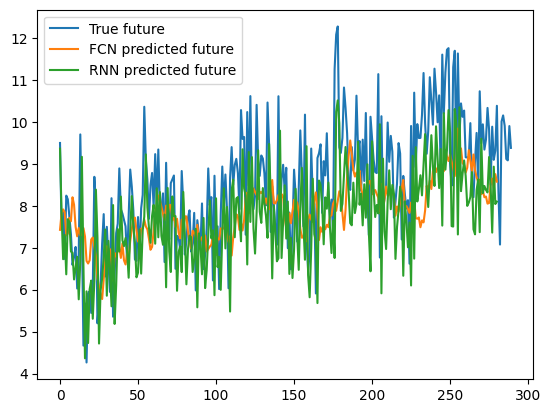

In [84]:
# predict on the test set and compare
fcn_predictions = fcn_model.predict(test)
rnn_predictions = simple_rnn.predict(test)
plt.plot(future[10:], label="True future")
plt.plot(fcn_predictions, label="FCN predicted future")
plt.plot(rnn_predictions, label="RNN predicted future")
plt.legend()

2160

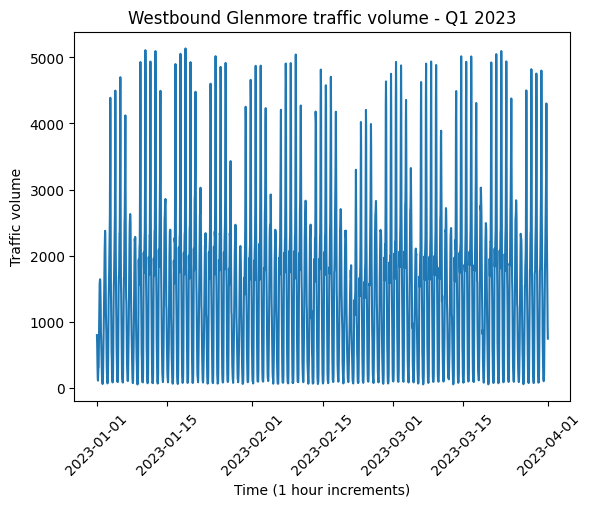

In [85]:
# real dataset
import pandas as pd

glenmore = pd.read_csv("glenmore_traffic.csv")
glenmore["STUDY_DATE"] = pd.to_datetime(
    glenmore["STUDY_DATE"], format=r"%m/%d/%Y %I:%M:%S %p"
)

# arbitrarily choose Jan - March
# also sum over 15 minutes to get hourly values
q1_start = "2023-01-01"
q1_end = "2023-04-01"
glenmore_wb_q1 = glenmore[
    (glenmore["DIRECTION"] == "W")
    & (glenmore["STUDY_DATE"] >= q1_start)
    & (glenmore["STUDY_DATE"] < q1_end)
]

wb_q1 = glenmore_wb_q1["VOLUME"].values.reshape(-1, 4).sum(axis=1)

# reshape(-1, 4) creates an N x 4 matrix, then sum(axis=1) brings it back to 1D
study_date = glenmore_wb_q1["STUDY_DATE"].values[::4]

plt.plot(study_date,wb_q1)
plt.xlabel("Time (1 hour increments)")
plt.ylabel("Traffic volume")
plt.xticks(rotation=45)
plt.title("Westbound Glenmore traffic volume - Q1 2023")
len(wb_q1)

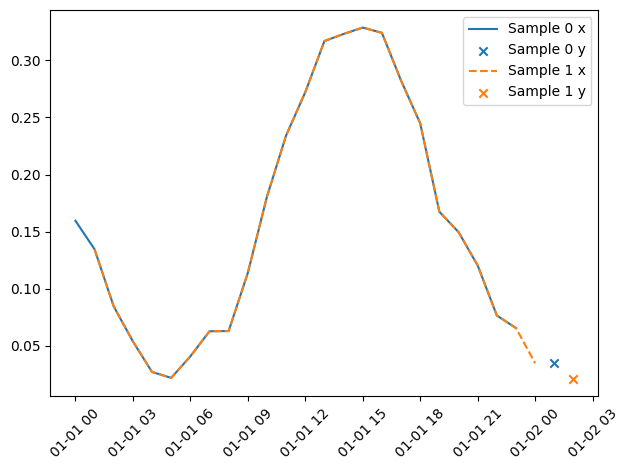

In [86]:
# Choose a reasonable time frame to split the data (no test set for now)
window = 24
train_end = len(wb_q1) * 4 // 5

# also scale to a more reasonable range
max_vol = 5000
wb_q1 = wb_q1.astype(float) / max_vol

traffic_train = to_ds(wb_q1[:train_end], input_width=window)
traffic_val = to_ds(wb_q1[train_end:], input_width=window)

fig, ax = plt.subplots(1, 1)

for batch in traffic_train:
    for i in range(2):
        x = batch[0][i,:]
        y = batch[1][i]

        ls = '-'
        if i == 1:
            ls = '--'
        ax.plot(study_date[i:window+i], x, label=f"Sample {i} x", linestyle=ls)
        ax.scatter(study_date[window+i+1], y, label=f"Sample {i} y", marker="x")
        ax.legend()
    break

plt.xticks(rotation=45)
plt.tight_layout()

In [87]:
# define a simple FCN
glenmore_fcn = tf.keras.models.Sequential(
    [
        tf.keras.Input(shape=(window,)),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

fit_model(glenmore_fcn, traffic_train, traffic_val, 0.02)

Epoch 1/500
53/53 [==============================] - 0s 3ms/step - loss: 0.0134 - mae: 0.1225 - val_loss: 0.0058 - val_mae: 0.0815
Epoch 2/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0048 - mae: 0.0709 - val_loss: 0.0038 - val_mae: 0.0639
Epoch 3/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0035 - mae: 0.0596 - val_loss: 0.0029 - val_mae: 0.0542
Epoch 4/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0030 - mae: 0.0534 - val_loss: 0.0025 - val_mae: 0.0490
Epoch 5/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0027 - mae: 0.0502 - val_loss: 0.0023 - val_mae: 0.0460
Epoch 6/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0025 - mae: 0.0481 - val_loss: 0.0022 - val_mae: 0.0441
Epoch 7/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0023 - mae: 0.0463 - val_loss: 0.0020 - val_mae: 0.0426
Epoch 8/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0022 - m

In [97]:
# And now the simple RNN
glenmore_rnn = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(None, 1)),
        tf.keras.layers.SimpleRNN(32, activation="tanh"), 
        tf.keras.layers.Dense(1)
    ]
)

fit_model(glenmore_rnn, traffic_train, traffic_val, 0.02)

Epoch 1/500
53/53 [==============================] - 1s 7ms/step - loss: 0.0247 - mae: 0.1544 - val_loss: 0.0048 - val_mae: 0.0745
Epoch 2/500
53/53 [==============================] - 0s 4ms/step - loss: 0.0052 - mae: 0.0753 - val_loss: 0.0034 - val_mae: 0.0662
Epoch 3/500
53/53 [==============================] - 0s 4ms/step - loss: 0.0035 - mae: 0.0621 - val_loss: 0.0025 - val_mae: 0.0547
Epoch 4/500
53/53 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0535 - val_loss: 0.0021 - val_mae: 0.0482
Epoch 5/500
53/53 [==============================] - 0s 4ms/step - loss: 0.0022 - mae: 0.0480 - val_loss: 0.0018 - val_mae: 0.0439
Epoch 6/500
53/53 [==============================] - 0s 5ms/step - loss: 0.0019 - mae: 0.0440 - val_loss: 0.0016 - val_mae: 0.0406
Epoch 7/500
53/53 [==============================] - 0s 4ms/step - loss: 0.0017 - mae: 0.0415 - val_loss: 0.0015 - val_mae: 0.0384
Epoch 8/500
53/53 [==============================] - 0s 4ms/step - loss: 0.0016 - m

13/13 [==============================] - 0s 2ms/step


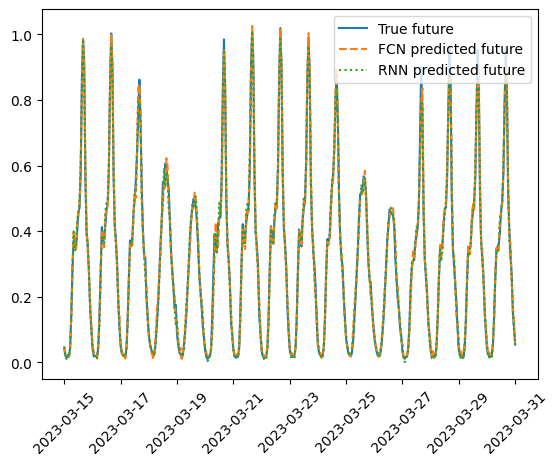

In [107]:
# Plot and compare
fcn_predictions = glenmore_fcn.predict(traffic_val)
rnn_predictions = glenmore_rnn.predict(traffic_val)
truth = wb_q1[train_end + window : -window + 1]
x = study_date[train_end + window : -window + 1]
plt.plot(x, truth, label="True future")
plt.plot(
    x,
    fcn_predictions,
    linestyle="--",
    label="FCN predicted future",
)
plt.plot(
    x,
    rnn_predictions,
    linestyle=":",
    label="RNN predicted future",
)
plt.xticks(rotation=45)
plt.legend()

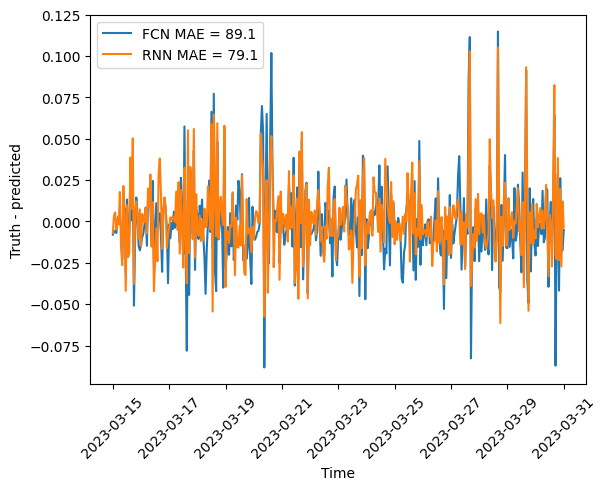

In [99]:
# Also calculate the difference and MAE
rnn_diff = truth - rnn_predictions.flatten()
fcn_diff = truth - fcn_predictions.flatten()

# Plot the difference
plt.plot(x, fcn_diff, label=f"FCN MAE = {np.abs(fcn_diff).mean() * max_vol:.1f}")
plt.plot(x, rnn_diff, label=f"RNN MAE = {np.abs(rnn_diff).mean() * max_vol:.1f}")
plt.xlabel("Time")
plt.ylabel("Truth - predicted")
plt.legend()
plt.xticks(rotation=45)
plt.show()

1/1 [==============================] - 0s 93ms/step


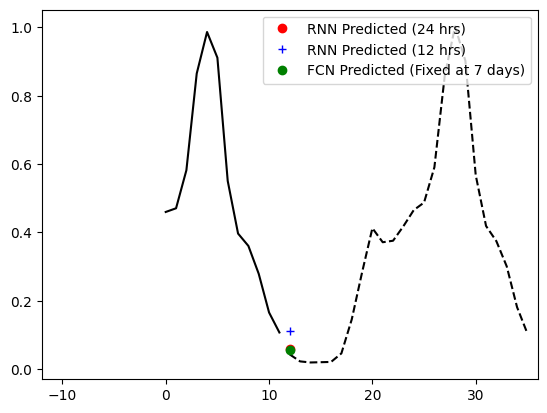

In [101]:
# What's the advantage of RNNs?
# try predicting on some chunk of data
chunk_end = train_end + window * 2
chunk_length = window
chunk = wb_q1[chunk_end - chunk_length : chunk_end]
truth = wb_q1[chunk_end]
r_predicted_24 = glenmore_rnn.predict(chunk.reshape(1, -1, 1))
f_predicted = glenmore_fcn.predict(chunk.reshape(1, -1))
chunk_length = 12
chunk = wb_q1[chunk_end - chunk_length : chunk_end]
r_predicted_var = glenmore_rnn.predict(chunk.reshape(1, -1, 1))

# what's the error?
plt.plot(chunk, "k")
plt.plot(
    np.arange(chunk_length, chunk_length + window),
    wb_q1[chunk_end : chunk_end + window],
    "k--",
)
plt.plot(chunk_length, r_predicted_24, "ro", label="RNN Predicted (24 hrs)")
plt.plot(
    chunk_length, r_predicted_var, "b+", label=f"RNN Predicted ({chunk_length} hrs)"
)
plt.plot(chunk_length, f_predicted, "go", label="FCN Predicted (Fixed at 7 days)")
plt.xlim([chunk_length - window, chunk_length + window])
plt.legend()

In [103]:
# A deeper RNN
deeper_rnn = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(None, 1)),
    tf.keras.layers.SimpleRNN(32, activation="tanh", return_sequences=True),
    tf.keras.layers.SimpleRNN(32, activation="tanh", return_sequences=True),
    tf.keras.layers.SimpleRNN(32, activation="tanh"), 
    tf.keras.layers.Dense(1)
])

fit_model(deeper_rnn, traffic_train, traffic_val, 0.02)

Epoch 1/500
53/53 [==============================] - 3s 15ms/step - loss: 0.0545 - mae: 0.2486 - val_loss: 0.0267 - val_mae: 0.1687
Epoch 2/500
53/53 [==============================] - 1s 10ms/step - loss: 0.0157 - mae: 0.1366 - val_loss: 0.0268 - val_mae: 0.2082
Epoch 3/500
53/53 [==============================] - 0s 9ms/step - loss: 0.0101 - mae: 0.1068 - val_loss: 0.0058 - val_mae: 0.0744
Epoch 4/500
53/53 [==============================] - 0s 9ms/step - loss: 0.0046 - mae: 0.0746 - val_loss: 0.0034 - val_mae: 0.0589
Epoch 5/500
53/53 [==============================] - 1s 10ms/step - loss: 0.0035 - mae: 0.0642 - val_loss: 0.0031 - val_mae: 0.0578
Epoch 6/500
53/53 [==============================] - 0s 9ms/step - loss: 0.0031 - mae: 0.0594 - val_loss: 0.0029 - val_mae: 0.0557
Epoch 7/500
53/53 [==============================] - 0s 9ms/step - loss: 0.0027 - mae: 0.0556 - val_loss: 0.0027 - val_mae: 0.0537
Epoch 8/500
53/53 [==============================] - 0s 9ms/step - loss: 0.0025 

In [104]:
# Try a GRU
glenmore_gru = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(None, 1)),
    tf.keras.layers.GRU(10), 
    tf.keras.layers.Dense(1)]
)

fit_model(glenmore_gru, traffic_train, traffic_val, 0.02)

Epoch 1/500
53/53 [==============================] - 2s 13ms/step - loss: 0.0196 - mae: 0.1542 - val_loss: 0.0113 - val_mae: 0.1262
Epoch 2/500
53/53 [==============================] - 0s 7ms/step - loss: 0.0092 - mae: 0.1126 - val_loss: 0.0093 - val_mae: 0.1130
Epoch 3/500
53/53 [==============================] - 0s 6ms/step - loss: 0.0081 - mae: 0.1028 - val_loss: 0.0084 - val_mae: 0.1046
Epoch 4/500
53/53 [==============================] - 0s 7ms/step - loss: 0.0073 - mae: 0.0956 - val_loss: 0.0076 - val_mae: 0.0970
Epoch 5/500
53/53 [==============================] - 0s 6ms/step - loss: 0.0066 - mae: 0.0888 - val_loss: 0.0068 - val_mae: 0.0897
Epoch 6/500
53/53 [==============================] - 0s 7ms/step - loss: 0.0060 - mae: 0.0822 - val_loss: 0.0062 - val_mae: 0.0829
Epoch 7/500
53/53 [==============================] - 0s 6ms/step - loss: 0.0054 - mae: 0.0761 - val_loss: 0.0056 - val_mae: 0.0766
Epoch 8/500
53/53 [==============================] - 0s 7ms/step - loss: 0.0050 - 

In [111]:
# Plot and compare
truth = wb_q1[train_end + window : -window + 1]
deeper_preds = deeper_rnn.predict(traffic_val)
gru_predictions = glenmore_gru.predict(traffic_val)
rnn_error = np.abs(rnn_predictions.flatten() - truth)
deeper_error = np.abs(deeper_preds.flatten() - truth)
gru_error = np.abs(gru_predictions.flatten() - truth)

# mean error
print(f"RNN mean absolute error: {np.abs(rnn_error).mean()*max_vol:.2f} Cars per hour")
print(f"Deeper RNN mean absolute error: {np.abs(gru_error).mean()*max_vol:.2f} Cars per hour")
print(f"GRU mean absolute error: {np.abs(gru_error).mean()*max_vol:.2f} Cars per hour")

13/13 [==============================] - 0s 2ms/step
RNN mean absolute error: 79.06 Cars per hour
Deeper RNN mean absolute error: 203.49 Cars per hour
GRU mean absolute error: 203.49 Cars per hour


67/67 [==============================] - 0s 3ms/step
GRU mean absolute error: 213.00 Cars per hour


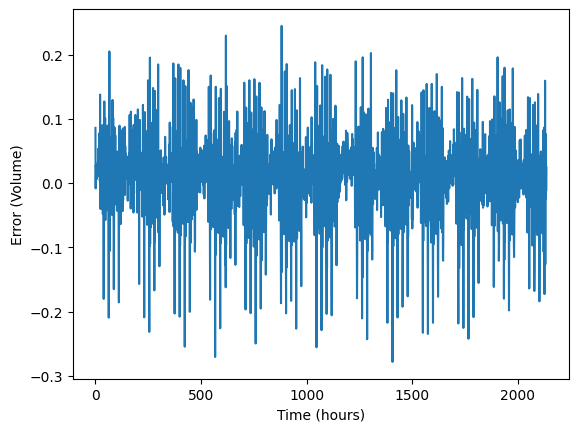

In [114]:
# try it on a totally separate 3-month period
wb_q2 = glenmore[
    (glenmore["DIRECTION"] == "W")
    & (glenmore["STUDY_DATE"] >= q1_end)
    & (glenmore["STUDY_DATE"] < "2023-07-01")
]["VOLUME"].values.reshape(-1, 4).sum(axis=-1).astype(float) / max_vol
q2_ds = to_ds(wb_q2, input_width=window)

# predict
gru_q2_pred = glenmore_gru.predict(q2_ds)
q2_error = gru_q2_pred.flatten() - wb_q2[window : -window + 1]

plt.plot(q2_error, label="Error")
plt.xlabel("Time (hours)")
plt.ylabel("Error (Volume)")

print(f"GRU mean absolute error: {np.mean(np.abs(q2_error))*max_vol:.2f} Cars per hour")